In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.special import logsumexp

from aeons.endpoint import EndModel, IncrementEndpoint, endpoints_calc, logXf_formula, reject_outliers, plot_endpoints
from aeons.tools import pickle_dump, pickle_in, proj_dir, chains, write_to_txt, read_from_txt, get_samples
from aeons.likelihoods import full
from aeons.lm_partial import analytic_lm_params
from aeons.true_distribution import generate_Xs
from aeons.covariance import points_at_iteration
from aeons.models import LS, GaussianRegress

/home/zixiao/Documents/III/project/aeons/aeons/covariance.py:89: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def X_mu(nk):
/home/zixiao/Documents/III/project/aeons/aeons/covariance.py:95: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def X_Sigma(nk):


In [40]:
figpath = f"{proj_dir}/notes/summer_4/Figures/"

def minimise_exclude(logL, X, print_split=False):
    logL, X = np.array(logL), np.array(X)
    logZmax = -np.inf
    theta_best = None
    split_best = None
    for splits in range(1, 5):
        start = len(X) - int(len(X)/splits)
        Xs, logLs = X[start:], logL[start:]
        regress = GaussianRegress(logLs, Xs)
        logZ = regress.logZ()
        theta = regress.theta
        if logZ > logZmax:
            logZmax = logZ
            theta_best = theta
            split_best = splits
    if print_split:
        print(f"Best split: {split_best}, {theta_best}")
    return theta_best

def minimise_bandwidth(logL, X, print_split=False):
    logZmax = -np.inf
    theta_best = None
    split_best = None
    for splits in range(1, 5):
        start = len(X) - int(len(X)/splits)
        Xs, logLs = X[start:], logL[start:]
        regress = GaussianRegress(logLs, Xs)
        theta = regress.theta
        # if np.isnan(logXf_formula(theta, logZdead, X[0])):
            # continue
        logZ = regress.logZ()
        if logZ > logZmax:
            logZmax = logZ
            theta_best = theta
            split_best = splits
    if print_split:
        print(f"Best split: {split_best}, {theta_best}")
    return theta_best

def formatt(theta):
    return [f"{t:.2f}" for t in theta]

## Rewriting class

In [46]:
def plot_lx(samples):
    logL = samples.logL
    logX_mean = samples.logX()
    fig, ax1 = plt.subplots(figsize=(6.7,2))
    ax2 = plt.twinx(ax1)
    logL_norm = logL - logL.max()
    L_norm = np.exp(logL_norm)
    ax1.plot(logX_mean, L_norm, lw=1, color='black')
    ax2.plot(logX_mean, L_norm*np.exp(logX_mean), lw=1, color='navy')
    ax1.set_title(f'logL_max = {logL.max():.2f}')

In [45]:
def add_logZ(samples):    
    logw = samples.logw()
    logZ = np.zeros_like(logw)
    logZ[0] = logw.iloc[0]
    for i in range(1, len(samples)):
        logZ[i] = logsumexp([logZ[i-1], logw.iloc[i]])
    samples['logZ'] = logZ
    return samples



class AEONSamples:
    def __init__(self, samples):
        self.samples = add_logZ(samples)
        self.logZ = self.samples['logZ']
        self.logX_mean = np.array(samples.logX())
        self.logL = np.array(samples.logL)
        self.L = np.exp(self.logL)
    
    def plot_lx(self):
        fig, ax1 = plt.subplots(figsize=(6.7,2))
        ax2 = plt.twinx(ax1)
        logL_norm = self.logL - self.logL.max()
        L_norm = np.exp(logL_norm)
        ax1.plot(self.logX_mean, L_norm)
        ax2.plot(self.logX_mean, L_norm*np.exp(self.logX_mean))
        ax1.set_title(f'logL_max = {self.logL.max():.2f}')

IndentationError: expected an indented block after function definition on line 10 (670071638.py, line 12)

## Predictions for planck_gaussian

In [31]:
samples = pickle_in('../../samples/toy/planck.pickle')

In [32]:
model = EndModel(samples)
inc = IncrementEndpoint(samples, N_rolling=500)
true_endpoint = inc.true_endpoint
logZs = inc.logZ

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/anesthetic/labelled_pandas.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results.append((f(*args), l))


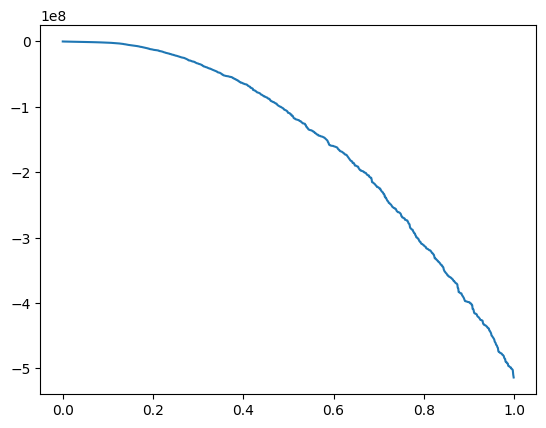

In [155]:
X, logL = np.exp(samples.logX()), samples.logL
ndead = 0
points = points_at_iteration(samples, ndead)
Xi, logLi = np.exp(points.logX()), points.logL
plt.plot(X, logL)

In [5]:
iterations = np.linspace(true_endpoint*0.1, true_endpoint, 25, endpoint=False).astype(int)
logXfs, logXfs_std = model.logXfs(iterations, Nset=25)

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/anesthetic/labelled_pandas.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results.append((f(*args), l))


Iteration 2747/26484
Iteration 3736/26484
Iteration 4725/26484
Iteration 5714/26484
Iteration 6703/26484
Iteration 7692/26484
Iteration 8681/26484
Iteration 9670/26484
Iteration 10659/26484
Iteration 11648/26484
Iteration 12638/26484
Iteration 13627/26484
Iteration 14616/26484
Iteration 15605/26484
Iteration 16594/26484
Iteration 17583/26484
Iteration 18572/26484
Iteration 19561/26484
Iteration 20550/26484
Iteration 21539/26484
Iteration 22528/26484
Iteration 23517/26484
Iteration 24506/26484
Iteration 25495/26484
Iteration 26484/26484


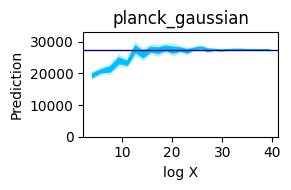

In [11]:
logXs = np.array(samples.logX().iloc[iterations])
endpoints, endpoints_std = endpoints_calc(iterations, logXs, logXfs, logXfs_std, nlive=750)
plt.figure(figsize=(3, 2))
plot_endpoints(iterations, endpoints, endpoints_std, true_endpoint, ylim=1.2, logX_vals=logXs)
plt.xlabel('log X')
plt.ylabel('Prediction')
plt.yticks(np.arange(0, 40000, 10000))
plt.title('planck_gaussian')
plt.tight_layout()
# plt.savefig(figpath+'planck_gaussian_predictions.pdf')

In [9]:
write_to_txt('planck_gaussian_predictions', [iterations, logXfs, logXfs_std, true_endpoint])

In [43]:
# Exclude last few points if they cause overflow
iterations = np.linspace(true_endpoint*0.1, true_endpoint, 25, endpoint=False).astype(int)
logXfs = np.zeros_like(iterations, dtype=float)
logXfs_std = np.zeros_like(iterations, dtype=float)
Nset = 25
trunc = 15
for k, ndead in enumerate(iterations):
    logZdead = logZs.iloc[ndead]
    points = points_at_iteration(samples, ndead)
    nk = np.array(points.nlive)
    logL = points.logL.iloc[ndead:]
    logXfs_i = np.zeros(Nset)
    thetas = []
    for i in range(Nset):
        X = generate_Xs(nk)
        theta = minimise_bandwidth(logL, X[ndead:], logZdead, print_split=False)
        attempt = 1
        while np.isnan(logXf_formula(theta, logZdead, X[ndead])):
            theta = minimise_bandwidth(logL[:-attempt*trunc], X[ndead:-attempt*trunc], logZdead, print_split=False)
            attempt += 1
        logXfs_i[i] = logXf_formula(theta, logZdead, X[ndead])
        thetas.append(theta)
    # logXfs_i = logXfs_i[~np.isnan(logXfs_i)]
    logXfs_i = reject_outliers(logXfs_i)
    logXfs[k] = np.mean(logXfs_i)
    logXfs_std[k] = np.std(logXfs_i)
    # print(thetas)
    print(f"{ndead}/{iterations[-1]}, {len(logXfs_i)}, attempts={attempt}")#, {formatt(np.mean(thetas, axis=0))}")

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/anesthetic/labelled_pandas.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results.append((f(*args), l))


2747/26484, 22, attempts=1
3736/26484, 20, attempts=1
4725/26484, 21, attempts=1
5714/26484, 17, attempts=1
6703/26484, 19, attempts=1
7692/26484, 21, attempts=1
8681/26484, 20, attempts=1
9670/26484, 16, attempts=1
10659/26484, 21, attempts=1
11648/26484, 19, attempts=1
12638/26484, 15, attempts=1
13627/26484, 23, attempts=1
14616/26484, 21, attempts=1
15605/26484, 20, attempts=1
16594/26484, 20, attempts=1
17583/26484, 17, attempts=1
18572/26484, 19, attempts=1
19561/26484, 19, attempts=1
20550/26484, 17, attempts=1
21539/26484, 17, attempts=1
22528/26484, 23, attempts=1
23517/26484, 22, attempts=1
24506/26484, 23, attempts=1
25495/26484, 19, attempts=1
26484/26484, 21, attempts=1


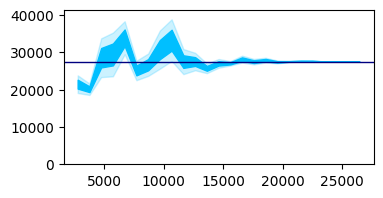

In [42]:
endpoints, endpoints_std = endpoints_calc(iterations, samples.logX().iloc[iterations], logXfs, logXfs_std, nlive=750)
plt.figure(figsize=(4, 2))
plot_endpoints(iterations, endpoints, endpoints_std, true_endpoint, ylim=1.5)

In [13]:
iterations = np.linspace(0.01*true_endpoint, true_endpoint, 50, endpoint=False).astype(int)
DKLs = np.zeros_like(iterations, float)
d_Gs = np.zeros_like(iterations, float)
ds = np.zeros(len(iterations))
for i, ndead in enumerate(iterations):
    points = points_at_iteration(samples, ndead)
    DKLs[i] = points.D_KL()
    d_Gs[i] = points.d_G()
    logX, logL = points.logX(), points.logL
    X = np.exp(logX)
    theta = analytic_lm_params(logL[ndead:], X[ndead:], d0=2)
    ds[i] = theta[1]
    print(ndead)

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/anesthetic/labelled_pandas.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results.append((f(*args), l))


274
818
1362
1906
2450
2994
3538
4082
4626
5170
5714
6258
6802
7346
7890
8434
8978
9522
10066
10610
11154
11698
12242
12786
13330
13874
14418
14962
15506
16050
16594
17138
17682
18226
18770
19314
19858
20402
20946
21490
22034
22578
23122
23666
24210
24754
25298
25842
26386
26930


In [15]:
logXf_true = samples.logX().iloc[true_endpoint]

In [16]:
write_to_txt('planck_gaussian_stats', [iterations, DKLs, d_Gs, ds, logXf_true])

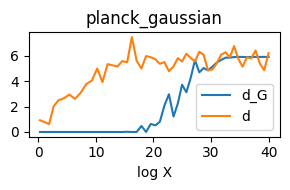

In [143]:
logXs = np.array(samples.logX().iloc[iterations])
plt.figure(figsize=(3,2))
plt.plot(-logXs, d_Gs, label='d_G')
plt.plot(-logXs, ds, label='d')
plt.yticks(np.arange(0, 7, 2))
plt.xlabel('log X')
plt.title('planck_gaussian')
plt.legend();
plt.tight_layout()
plt.savefig(figpath+'planck_gaussian_d.pdf')

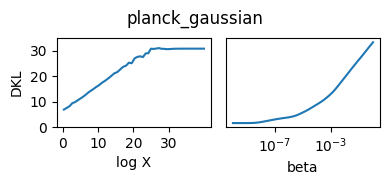

In [128]:
fig, axs = plt.subplots(1,2, figsize=(4,2))
axs[0].plot(-logXs, DKLs)
axs[0].set_ylim(0, 35)
axs[0].set_xticks(np.arange(0, 35, 10))
axs[0].set_yticks(np.arange(0, 35, 10))
axs[0].set_xlabel('log X')
axs[0].set_ylabel('DKL')

beta = np.logspace(-10, 0, 100)
D_KL = samples.D_KL(nsamples=1, beta=np.logspace(-10, 0, 100))
D_KL.unstack('samples').plot(legend=False, logx=True, ax=axs[1], yticks=[])
fig.suptitle('planck_gaussian', y=.9)
fig.tight_layout()
fig.savefig(figpath+'planck_gaussian_DKL.pdf')

# **DKL**

In [2]:
name, samples = get_samples('lcdm', 'planck')

<Axes: xlabel='beta'>

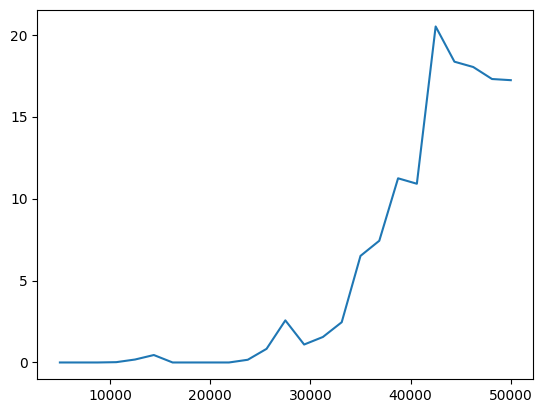

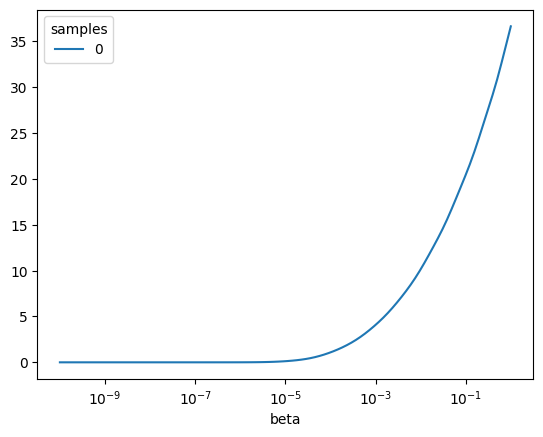

In [19]:
plt.plot(iterations, d_Gs)

<Axes: xlabel='beta'>

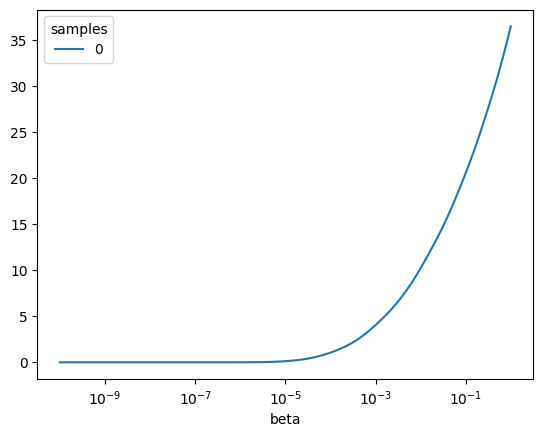

In [64]:
name, samples = get_samples('lcdm', 'planck')
beta = np.logspace(-10, 0, 100)
D_KL = samples.D_KL(nsamples=1, beta=np.logspace(-10, 0, 100))
D_KL.unstack('samples').plot(logx=True)

In [51]:
ndead = 15000
points = points_at_iteration(samples, ndead)

/home/zixiao/Documents/III/project/env/lib/python3.10/site-packages/anesthetic/labelled_pandas.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results.append((f(*args), l))


<Axes: xlabel='beta'>

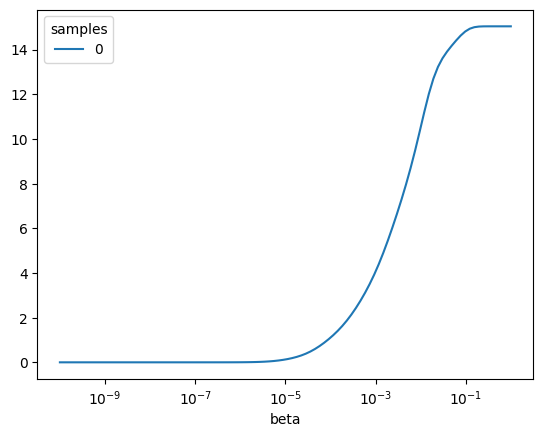

In [56]:
beta = np.logspace(-10, 0, 100)
D_KL = points.D_KL(nsamples=1, beta=np.logspace(-10, 0, 100))
D_KL.unstack('samples').plot(logx=True)

In [11]:
samples.D_KL()

31.008685697592174